# Data Exploration for a Machine Learning Stock Predictor

In [8]:
# import needed libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Helper functions
---

Global functions intended to make computations easier. These are also developed with the intention to be used in the final code implimentaion

In [100]:

################################################
# Data Gathering Helpers
################################################
def path_to_data(ticker, base_dir='data'):
    return os.path.join(base_dir, '{}.csv'.format(ticker))

def fetch_data(ticker_list, dates):
    df = pd.DataFrame(index=dates)
    ticker_list.insert(0, 'SPY')
    for ticker in range(0, len(ticker_list)):
        df_temp = pd.read_csv(
            path_to_data(ticker_list[ticker]), 
            usecols=['Date', 'Adj Close'], 
            index_col='Date', 
            parse_dates=True, 
            na_values=['nan'])
        df_temp = df_temp.rename(columns={'Adj Close' : ticker_list[ticker]})
        df = df.join(df_temp)
    
    df = df.dropna(subset=['SPY'])
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df

################################################
# STATS Helpers
################################################
def normalize_data(df):
    return df/df.ix[0,:]

def get_cumulative_returns(df):
    return df/df.ix[0,:]

def get_daily_returns(df):
    return df/df.ix[0,:]

# rolling stats
def get_rolling_mean(vals, window=20):
    return vals.rolling(window,center=False).mean()

def get_rolling_std(vals, window=20):
    return vals.rolling(window,center=False).std()

def get_bollinger_bands(rolling_mean, rolling_std):
    lower_band = rolling_mean - (rolling_std * 2)
    upper_band = rolling_mean + (rolling_std * 2)
    return lower_band, upper_band


################################################
# Graph Plotting Helpers
################################################
def print_bollinger_bands(series, label=''):
    rolling_mean = get_rolling_mean(series)
    rolling_std = get_rolling_std(series)
    lower_band, upper_band = get_bollinger_bands(rolling_mean, rolling_std)
    
    val = ax = series.plot(title='Bollinger Bands: ' + label, label='Prices', fontsize=10)
    rm = rolling_mean.plot(label='Rolling Mean', ax=ax)
    ub = upper_band.plot(label='Upper Band', ax=ax)
    lb = lower_band.plot(label='Lower Band', ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='best')
    plt.show()
    
def plot_data(df, title='Stock Prices', xlabel='Date', ylabel='Price'):
    ax = df.plot(title=title, fontsize=10)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

## Process Data for Selected Stocks
---

In [22]:
# use two years of dates for data exploration
dates = pd.date_range('2015-07-14', '2017-07-14')

# These will be the tickers we will be working with to build our model
# SPY is added as a benchmark model. 
tickers = ['GOOG', 'AAPL', 'NVDA', 'IBM']

# fetch the data for the dates and tickers selected
df_full_data = fetch_data(tickers, dates)
df_explore = df_full_data.drop('SPY', 1)

print 'Total days traded during dates: ' + str(len(df_explore))
print df_full_data.head(n=5)
print '\nCreate a new DF without SnP 500, since it was only used to varify trading days. But we may still want it for some comparisons.'
print df_explore.head(n=5)

Total days traded during dates: 506
                   SPY        GOOG        AAPL       NVDA         IBM
2015-07-14  210.679993  561.099976  125.610001  19.889999  168.610001
2015-07-15  210.610001  560.219971  126.820000  19.750000  168.529999
2015-07-16  212.300003  579.849976  128.509995  20.190001  171.000000
2015-07-17  212.479996  672.929993  129.619995  20.070000  172.509995
2015-07-20  212.589996  663.020020  132.070007  19.700001  173.220001

Create a new DF without SnP 500, since it was only used to varify trading days. But we may still want it for some comparisons.
                  GOOG        AAPL       NVDA         IBM
2015-07-14  561.099976  125.610001  19.889999  168.610001
2015-07-15  560.219971  126.820000  19.750000  168.529999
2015-07-16  579.849976  128.509995  20.190001  171.000000
2015-07-17  672.929993  129.619995  20.070000  172.509995
2015-07-20  663.020020  132.070007  19.700001  173.220001


## Visualize the Data of the Selected Stocks
---


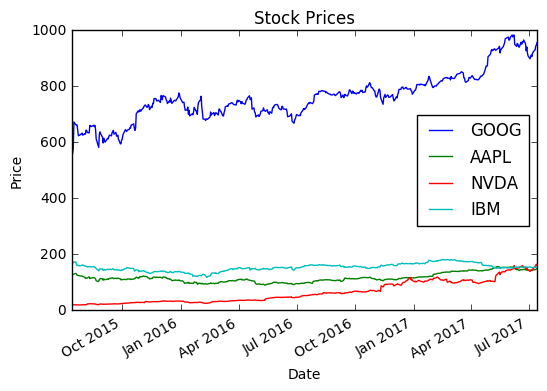

In [23]:
plot_data(df_explore)

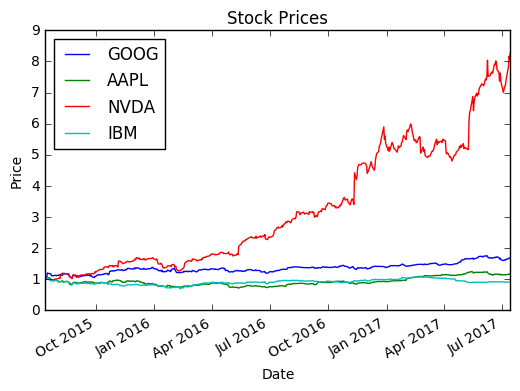

In [24]:
normalized_data = normalize_data(df_explore)
plot_data(normalized_data)

## Global Stats
---

Global stats of the stocks we are interested in

---

In [25]:
print 'Global Mean:\n' + str(normalized_data.mean()) + '\n'
print 'Global Median:\n' + str(normalized_data.median()) + '\n'
print 'Global Std:\n' + str(normalized_data.std()) + '\n'

Global Mean:
GOOG    1.357082
AAPL    0.927906
NVDA    3.246513
IBM     0.910470
dtype: float64

Global Median:
GOOG    1.347870
AAPL    0.899809
NVDA    2.654098
IBM     0.909703
dtype: float64

Global Std:
GOOG    0.154974
AAPL    0.134810
NVDA    1.982375
IBM     0.078761
dtype: float64



## Rolling Stats
---

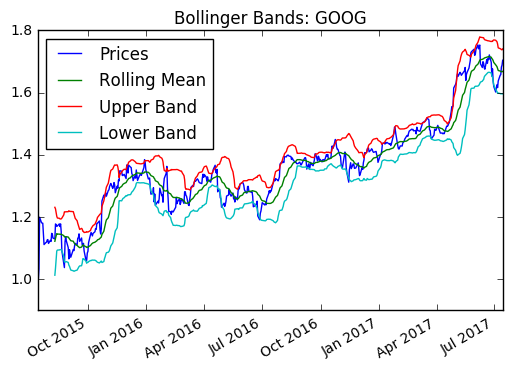

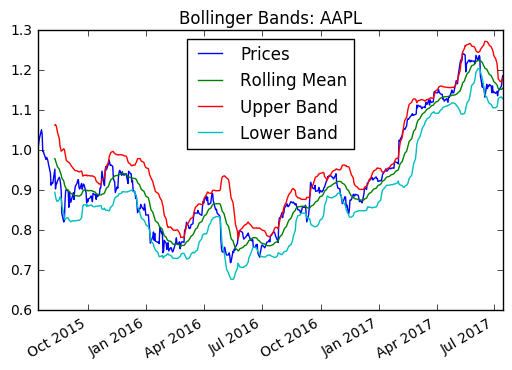

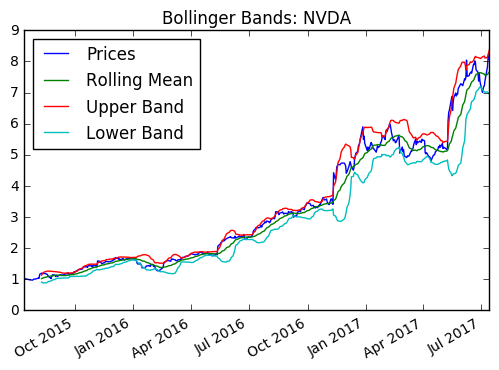

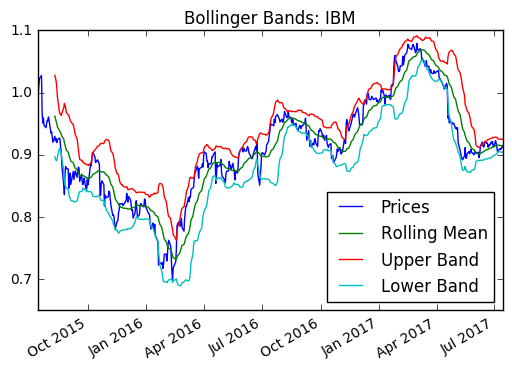

In [101]:
for stock in normalized_data:
    print_bollinger_bands(normalized_data[stock], label=stock)

## Daily Returns
---

## Cumulative Returns
---